<a href="https://colab.research.google.com/github/3shry/3shry/blob/master/notebooks/StyleCLIP_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery

In [1]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

% cd
% cd /content/

! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/orpatashnik/StyleCLIP

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1MB 1.3MB/s eta 0:04:07tcmalloc: large alloc 1147494400 bytes == 0x5616e6e8e000 @  0x7facc281b615 0x5616ad924cdc 0x5616ada0452a 0x5616ad927afd 0x5616ada18fed 0x5616ad99b988 0x5616ad9964ae 0x5616ad9293ea 0x5616ad99b7f0 0x5616ad9964ae 0x5616ad9293ea 0x5616ad99832a 0x5616ada19e36 0x5616ad997853 0x5616ada19e36 0x5616ad997853 0x5616ada19e36 0x5616ad997853 0x5616ada19e36 0x5616ada9c3e1 0x5616ad9fc6a9 0x5616ad967cc4 0x5616ad928559 0x5616ad99c4f8 0x5616ad92930a 0x5616ad9973b5 0x5616ad9967ad 0x5616ad9293ea 0x5616ad9973b5 0x5616ad92930a 0x5616ad9973b5
     |█████████████████████████████▏  | 1055.7MB 1.2MB/s eta 0:01:25tcmalloc: large alloc 1434370048 bytes == 0x56172b4e4000 @  0x7facc281b615 0x5616ad924cdc 0x5616ada0452a 0x5616ad927afd 0x5616ada18fed 0x5616ad99b988 0x5616ad9964ae 0x5616ad9293ea 0x5616ad99b7f0 0x5616ad9964ae 0x5616ad9293ea 0x5616ad99832a 0x5616

# Select dataset 
If you want to use another dataset, please restart runtime. currently, we only support ffhq.

In [ ]:
dataset_name='ffhq' #@param ['ffhq'] {allow-input: true}
# input dataset name 

% cd
% cd /content/StyleCLIP/global_directions/

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
from gdown import download as drive_download
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

image_path = None
img_index = None

# Upload an Image
This section can be skipped if you prefer to edit generated image.

In [3]:
#@title e4e setup
#@ e4e setup 
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

1.20GB [00:12, 96.7MB/s]


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


Aligned image has shape: (256, 256)


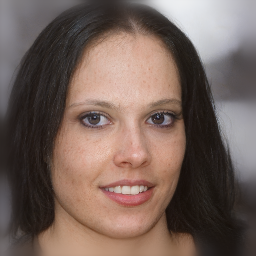

In [32]:
#@title Align image
image_path = "/content/A_enhance 3_black_hair.png" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

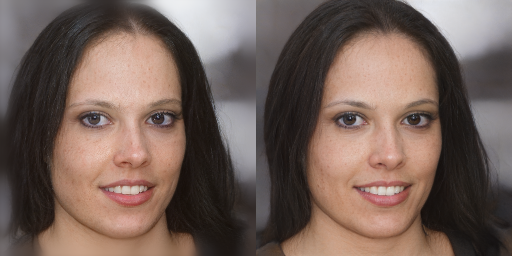

In [35]:
#@title Invert the image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)




# Choose Image Index
Relevant only when editing generated image
 

In [ ]:
img_index =  1#@param {type:"number"}

# Choose Mode (and show input image)
Run for both real and generated image

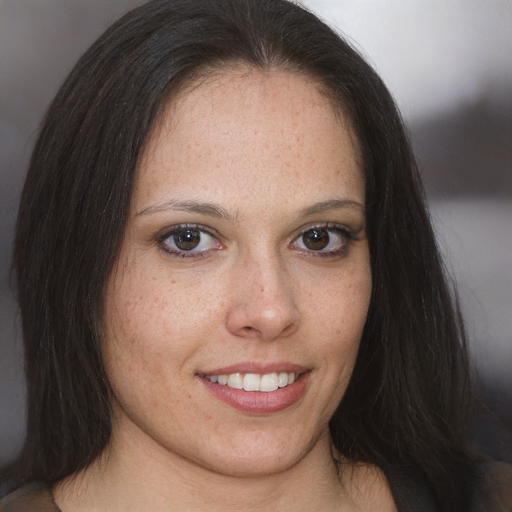

In [36]:
mode='real image' #@param ['real image', 'generated image']

if mode == 'real image':
  img_index = 0
  latents=torch.load('/content/encoder4editing/latents.pt')
  w_plus=latents.cpu().detach().numpy()
  dlatents_loaded=M.W2S(w_plus)

  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
elif mode == 'generated image':
  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original


# input text description 
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |


In [37]:
neutral=' face with eyes ' #@param {type:"string"}
target=' face with blue eyes ' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.3662


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

num of channels being manipulated: 19


(-0.5, 1023.5, 1023.5, -0.5)

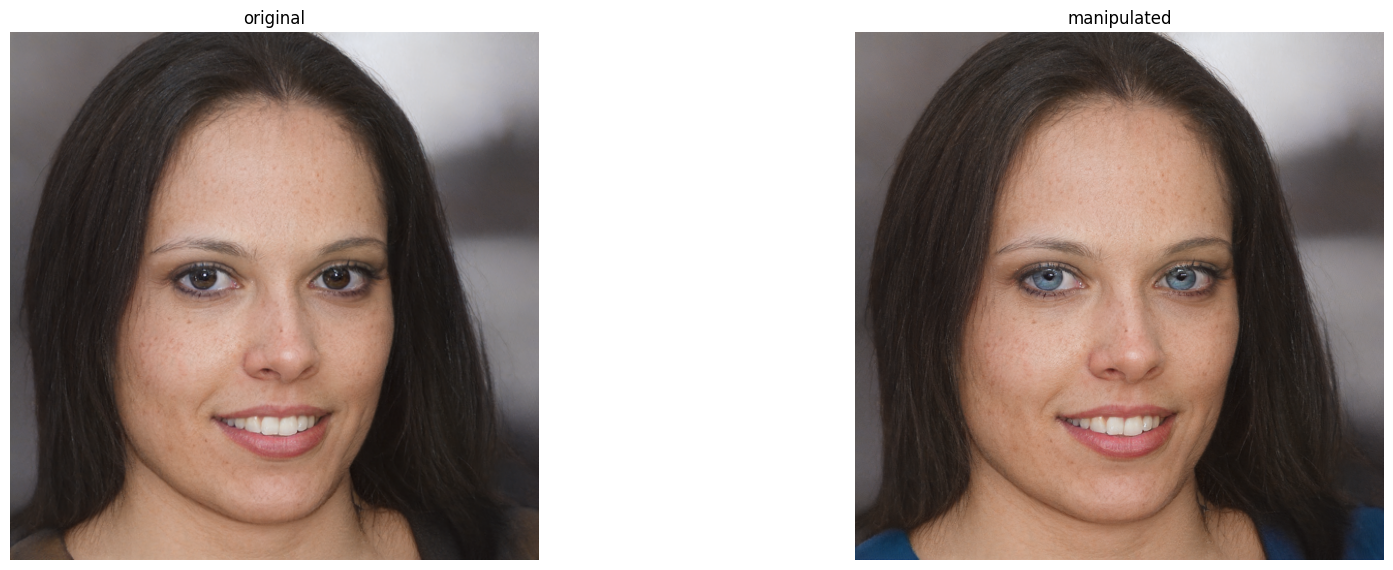

In [46]:

#beta=0.1
#alpha=1
beta = 0.17 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 6 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

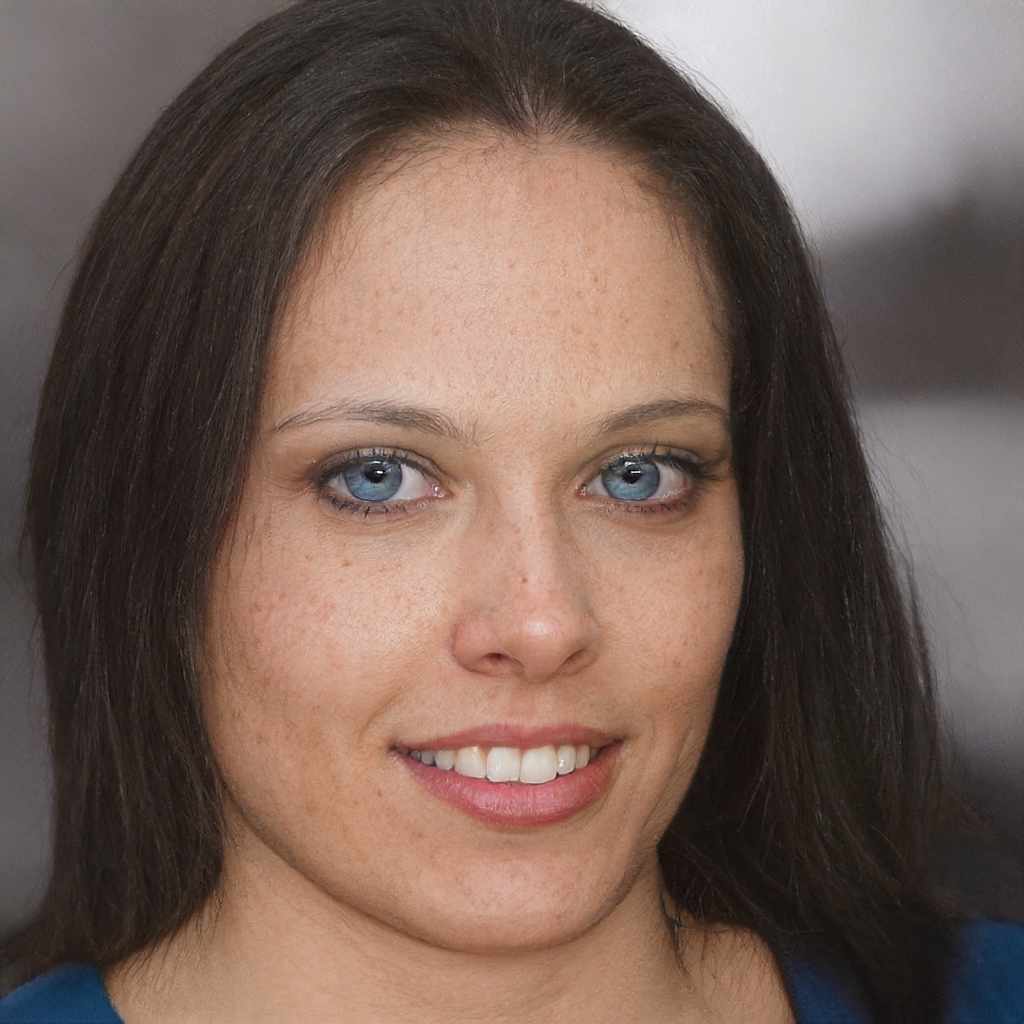

In [47]:
#@title generate a high-res manipulated photo for download
generated

# video

Renders a video interpolating from the base image with provided `beta` to the `target_alpha`. (`target_alpha` can be positive or negative)

In [ ]:
from contextlib import contextmanager
import sys, os
from tqdm.notebook import tqdm

beta =  0.15 #@param {type:"number"}
target_alpha =  4.1#@param {type:"number"}
num_frames = 350 #@param {type:"number"}
frame_rate = 60 #@param {type:"number"}

!rm -rf /content/results
!mkdir /content/results

# Mute GetBoundary()
# https://stackoverflow.com/a/25061573
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

def gen_image(beta, alpha, i):
  M.alpha=[alpha]
  with suppress_stdout():
    boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
  codes=M.MSCode(dlatent_tmp,boundary_tmp2)
  out=M.GenerateImg(codes)
  Image.fromarray(out[0,0]).save(f"/content/results/{i:04d}.png")

alphas = np.linspace(0, target_alpha, num_frames)

print("Generating Frames:")
for i, alpha in tqdm(enumerate(alphas), total=num_frames):
  gen_image(beta, alpha, i)

print("Rendering Video...")
result = os.system(f"ffmpeg -y -r {frame_rate} -i /content/results/%04d.png -c:v libx264 -vf fps={frame_rate} -pix_fmt yuv420p /content/styleclip.mp4")
print("Video saved at styleclip.mp4!")

from google.colab import files
files.download('/content/styleclip.mp4')

Generating Frames:



Rendering Video...
Video saved at styleclip.mp4!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>